In [ ]:
import numpy as np
import pandas as pd

# Define the entropy function
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy_value = np.sum([(-counts[i]/np.sum(counts)) * np.log2(counts[i]/np.sum(counts))
                            for i in range(len(elements))])
    return entropy_value

In [ ]:
# Define the Gini index function
def gini_index(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    gini_value = 1 - np.sum([(counts[i]/np.sum(counts))**2 for i in range(len(elements))])
    return gini_value

In [ ]:
# Function to calculate the best attribute to split on using entropy or Gini index
def best_attribute_to_split(data, attributes, target_attribute_name, criterion):
    if criterion == "entropy":
        best_info_gain = -1
        best_attribute = None
        current_entropy = entropy(data[target_attribute_name])

        for attribute in attributes:
            attribute_entropy = 0
            attribute_values = data[attribute].unique()
            for value in attribute_values:
                sub_data = data[data[attribute] == value]
                sub_entropy = entropy(sub_data[target_attribute_name])
                attribute_entropy += (len(sub_data) / len(data)) * sub_entropy

            info_gain = current_entropy - attribute_entropy
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_attribute = attribute

        return best_attribute

    elif criterion == "gini":
        best_gini_index = float("inf")
        best_attribute = None
        current_gini_index = gini_index(data[target_attribute_name])

        for attribute in attributes:
            attribute_gini = 0
            attribute_values = data[attribute].unique()
            for value in attribute_values:
                sub_data = data[data[attribute] == value]
                sub_gini = gini_index(sub_data[target_attribute_name])
                attribute_gini += (len(sub_data) / len(data)) * sub_gini

            gini_gain = current_gini_index - attribute_gini
            if gini_gain < best_gini_index:
                best_gini_index = gini_gain
                best_attribute = attribute

        return best_attribute

In [ ]:
# Function to build the decision tree
def build_decision_tree(data, original_data, features, target_attribute_name, parent_node_class=None, criterion="entropy"):
    # If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]

    # If the feature space is empty, return the mode target feature value of the direct parent node
    elif len(features) == 0:
        return parent_node_class

    # If none of the above conditions holds true, grow the tree!
    else:
        # Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        # Select the feature which best splits the dataset
        best_feature = best_attribute_to_split(data, features, target_attribute_name, criterion)

        # Create the tree structure. The root gets the name of the best feature
        tree = {best_feature: {}}

        # Remove the feature with the best info_gain
        features = [i for i in features if i != best_feature]

        # Grow a branch under the root node for each possible value of the root node feature
        for value in np.unique(data[best_feature]):
            value = value
            # Split the dataset along the value of the feature with the largest information gain and therewith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()

            # Call the build_decision_tree function for each of those sub_datasets with the new parameters
            subtree = build_decision_tree(sub_data, original_data, features, target_attribute_name, parent_node_class, criterion)

            # Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree

        return tree

In [ ]:
# Manually split the data
def manual_train_test_split(df, test_size, random_state):
    np.random.seed(random_state)
    permutation = np.random.permutation(df.index)
    length = len(df)
    test_length = int(length * test_size)

    test_indices = permutation[:test_length]
    train_indices = permutation[test_length:]

    return df.loc[train_indices], df.loc[test_indices]

In [ ]:
# Load the dataset
file_path = '/content/lending-club-data3a.csv'
data = pd.read_csv(file_path)

# Split the data into training and testing set
train_data, test_data = manual_train_test_split(data, test_size=0.20, random_state=123)

# Features for the decision tree (excluding the target feature)
features = train_data.columns.tolist()
features.remove('y')

# Build the decision tree using entropy
tree_entropy = build_decision_tree(train_data, train_data, features, 'y', criterion="entropy")

# Output the decision tree built based on entropy
tree_entropy

{'income': {'high': 'risky',
  'low': 'safe',
  'middle': {'credit': {'excellent': {'term': {'3yrs': 'safe',
      '5yrs': 'safe'}},
    'fair': {'term': {'3yrs': 'safe', '5yrs': 'safe'}},
    'poor': {'term': {'3yrs': 'risky', '5yrs': 'risky'}}}}}}

2

In [ ]:
# Function to predict a single data point using the decision tree
def predict(tree, data_point):
    for nodes in tree.keys():
        value = data_point[nodes]
        tree = tree[nodes][value]
        prediction = 0

        if type(tree) is dict:
            prediction = predict(tree, data_point)
        else:
            prediction = tree
            break;

    return prediction

# Function to predict the entire dataset
def predict_dataset(data, tree):
    predictions = data.apply(lambda x: predict(tree, x), axis=1)
    return predictions

# Generate predictions for the train and test datasets
train_predictions = predict_dataset(train_data, tree_entropy)
test_predictions = predict_dataset(test_data, tree_entropy)


In [ ]:
# Function to calculate the confusion matrix
def confusion_matrix(true_labels, predictions):
    tp = sum((true_labels == "safe") & (predictions == "safe"))
    tn = sum((true_labels == "risky") & (predictions == "risky"))
    fp = sum((true_labels == "risky") & (predictions == "safe"))
    fn = sum((true_labels == "safe") & (predictions == "risky"))
    return tp, tn, fp, fn

# Function to calculate accuracy
def accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

# Function to calculate precision
def precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) != 0 else 0

# Function to calculate recall
def recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) != 0 else 0

# Function to calculate F1 score
def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Calculate metrics for the training set
train_tp, train_tn, train_fp, train_fn = confusion_matrix(train_data['y'], train_predictions)
train_accuracy = accuracy(train_tp, train_tn, train_fp, train_fn)
train_precision = precision(train_tp, train_fp)
train_recall = recall(train_tp, train_fn)
train_f1 = f1_score(train_precision, train_recall)

# Calculate metrics for the testing set
test_tp, test_tn, test_fp, test_fn = confusion_matrix(test_data['y'], test_predictions)
test_accuracy = accuracy(test_tp, test_tn, test_fp, test_fn)
test_precision = precision(test_tp, test_fp)
test_recall = recall(test_tp, test_fn)
test_f1 = f1_score(test_precision, test_recall)

# Output the performance metrics
train_metrics = (train_accuracy, train_precision, train_recall, train_f1)
test_metrics = (test_accuracy, test_precision, test_recall, test_f1)
train_metrics, test_metrics

((0.8190625, 0.8226507547617166, 0.9411392405063291, 0.8779150676843925),
 (0.81625, 0.8189026324135744, 0.9402767662053897, 0.8754026106119682))

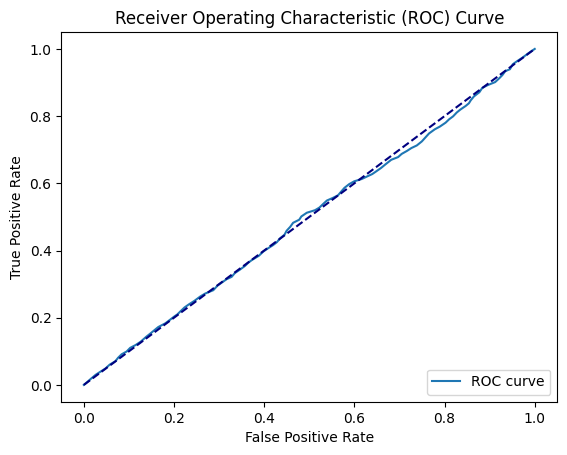

AUC: -0.49775837494816305


In [ ]:
import matplotlib.pyplot as plt

# Function to calculate TPR and FPR
def tpr_fpr_rates(y_true, y_scores, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        # Convert scores to binary predictions
        y_pred = (y_scores >= threshold).astype(int)
        tp = sum((y_true == 1) & (y_pred == 1))
        tn = sum((y_true == 0) & (y_pred == 0))
        fp = sum((y_true == 0) & (y_pred == 1))
        fn = sum((y_true == 1) & (y_pred == 0))

        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return tpr, fpr

# Assuming we have a y_scores which is a numpy array of continuous scores
# For demonstration, we're using random scores here
np.random.seed(123)
y_scores = np.random.rand(len(test_data))
thresholds = np.linspace(0, 1, 100)

# Calculate TPR and FPR at different thresholds
y_true_binary = (test_data['y'] == 'safe').astype(int)  # Convert labels to binary
tpr, fpr = tpr_fpr_rates(y_true_binary, y_scores, thresholds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Function to calculate AUC
def auc(fpr, tpr):
    return np.trapz(tpr, fpr)

# Calculate AUC
auc_value = auc(fpr, tpr)
print("AUC:", auc_value)